## Importing necessary libraries

In [1]:
#@title
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

## Dataset Structure

- Three parent folders 'train', 'val', 'test'.
- Each folder contains two subfolders, 'NORMAL', and 'PNEUMONIA'.

I will import all three datasets to explore the sizes and class distribution.

In [2]:
# data paths
dataset_dir = 'chest_xray'
train_folder = os.path.join(dataset_dir, 'train')
val_folder = os.path.join(dataset_dir, 'val')
test_folder = os.path.join(dataset_dir, 'test')
im_size = 224

In [77]:
# defining a function to load images, resize, and convert to grayscale

def load_images(folder_path):
    images = []
    labels = []

    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if not os.path.isdir(subfolder_path):
            continue

        label = 'Normal' if subfolder == 'NORMAL' else 'Pneumonia'

        for filename in os.listdir(subfolder_path):
            file_path = os.path.join(subfolder_path, filename)
            img = cv2.imread(file_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (im_size, im_size))
            img = np.expand_dims(img, axis=-1) # adding back color channel
            images.append(img)
            labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    return images, labels

In [78]:
# importing data

train_images, train_labels = load_images(train_folder)
val_images, val_labels = load_images(val_folder)
test_images, test_labels = load_images(test_folder)

In [79]:
# Saving variables

# import pickle

# with open('xray_data.pickle', 'wb') as f:
#   pickle.dump((train_images, test_images, train_labels, test_labels, val_images, val_labels), f)

#     # Use this to load variables
# with open('xray_data.pickle', 'rb') as f:
#    (train_images, test_images, train_labels, test_labels) = pickle.load(f)

In [6]:
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape, val_images.shape, val_labels.shape
# (5216, 224, 224, 1) (5216,), (624, 224, 224, 1) (624,), (16, 224, 224, 1) (16,)

((5216, 224, 224, 1),
 (5216,),
 (624, 224, 224, 1),
 (624,),
 (16, 224, 224, 1),
 (16,))

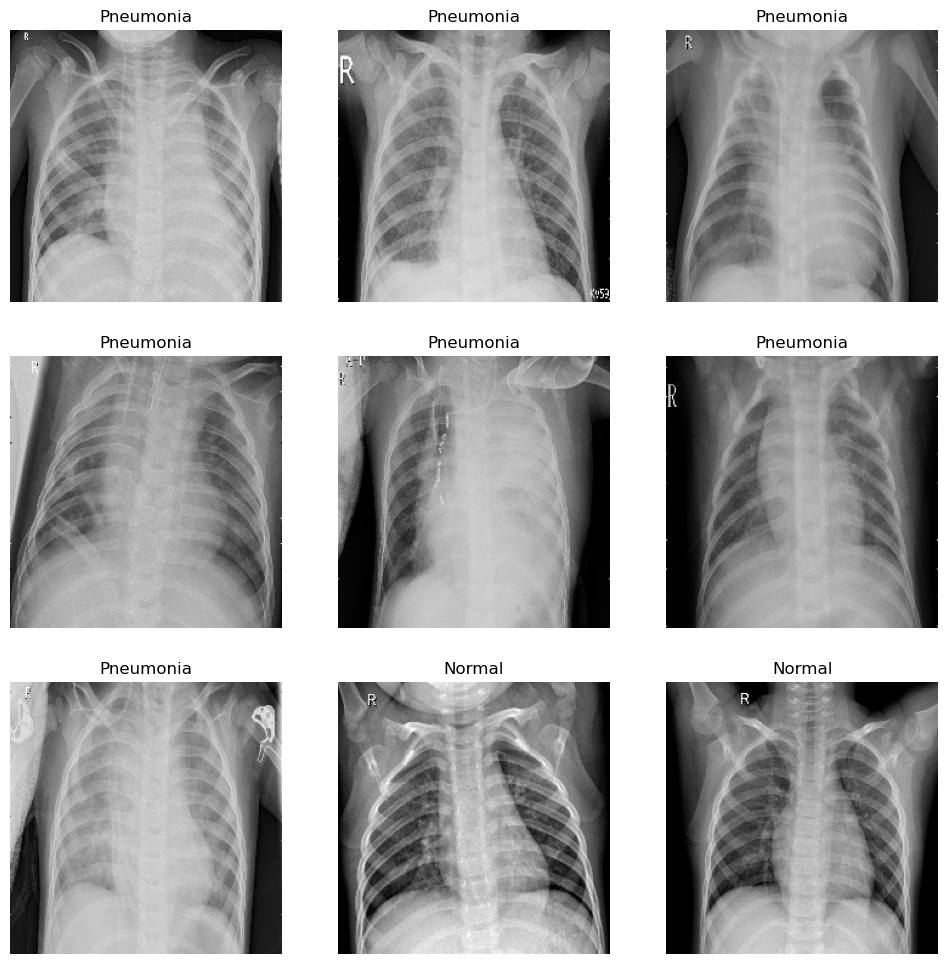

In [7]:
# Sample data for visualizing 

plt.figure(figsize=(12,12))
idx = list(np.random.randint(len(train_images), size=9))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(train_images[idx[i]], cmap='gray')
    plt.title(train_labels[idx[i]])
    plt.axis('off')
plt.show()

## Data Augmentation using SMOTE

In [8]:
print(np.asarray(np.unique(train_labels, return_counts=True)).T)

[['Normal' '1341']
 ['Pneumonia' '3875']]


In [9]:
print(np.asarray(np.unique(test_labels, return_counts=True)).T)

[['Normal' '234']
 ['Pneumonia' '390']]


In [10]:
images_flattened = train_images.reshape(train_images.shape[0], -1)

from imblearn.over_sampling import SMOTE
smote = SMOTE()

In [11]:
images_resampled, labels_resampled = smote.fit_resample(images_flattened, train_labels)

images_resampled = images_resampled.reshape(-1, train_images.shape[1], train_images.shape[2], train_images.shape[3])

images_resampled.shape, labels_resampled.shape

((7750, 224, 224, 1), (7750,))

In [12]:
np.unique(labels_resampled)

array(['Normal', 'Pneumonia'], dtype='<U9')

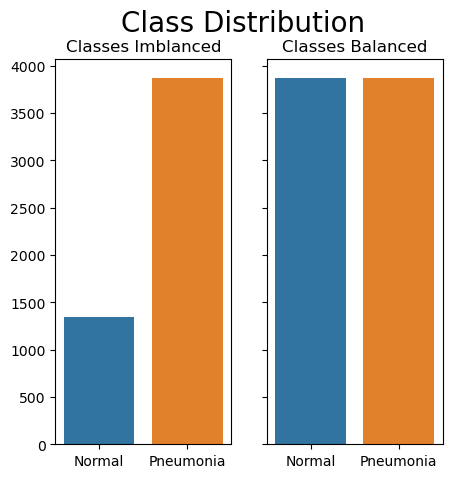

[1341 3875] [3875 3875]


In [13]:
unique1, counts1 = np.unique(train_labels, return_counts=True)
unique2, counts2 = np.unique(labels_resampled, return_counts=True)

fig, ax = plt.subplots(1,2, sharey=True,figsize=(5,5))
fig.suptitle('Class Distribution', fontsize=20)
sns.barplot(ax=ax[0], x=unique1, y=counts1)
ax[0].set_title('Classes Imblanced')
sns.barplot(ax=ax[1], x=unique2, y=counts2)
ax[1].set_title('Classes Balanced')
plt.xticks(range(len(unique1)), unique1)
plt.show()

print(counts1, counts2)

## Shuffle training data

In [ ]:
from sklearn.utils import shuffle
train_images_shuffled, train_labels_shuffled = shuffle(images_resampled, train_labels, random_state=42)

## Normalize Image data

In [19]:
X_train = train_images_shuffled / 255.0
X_test = test_images / 255.0
X_val = val_images / 255.0

In [20]:
X_train.shape, X_test.shape

((7750, 224, 224, 1), (624, 224, 224, 1))

## Data encoding

Since this is a binary classification problem we can use Label Indexing.

In [14]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

train_labels_encoded = encoder.fit_transform(labels_resampled)
test_labels_encoded = encoder.fit_transform(test_labels)
val_labels_encoded = encoder.fit_transform(val_labels)

In [16]:
print(np.asarray(np.unique(train_labels_encoded, return_counts=True)).T)

[[   0 3875]
 [   1 3875]]
